dataset  (classification) https://www.kaggle.com/datasets/alfathterry/bbc-full-text-document-classification


In [1]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torch
import re
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AdamW
from transformers import AutoTokenizer, LongT5Model
import torch.nn.functional as F
import torch.nn as nn
import re

### RNN - Recurrent neural network
https://www.youtube.com/watch?v=4wuIOcD1LLI&t=2640s

In [2]:
class RNN(torch.nn.Module):

  def __init__(self, embedding_dims, hidden_size, output_size):

    # output size can be num of classification categories

    super(RNN, self).__init__()

    self.embedding_dims = embedding_dims
    self.hidden_size = hidden_size
    self.output_size = output_size

    self.input_weights = nn.Linear(self.embedding_dims, self.hidden_size)
    self.hidden_weights = nn.Linear(self.hidden_size, self.hidden_size)
    self.output_weights = nn.Linear(self.hidden_size, self.output_size)


  def forward(self, sequence):

    hidden_state = torch.zeros((1, self.hidden_size))

    for i in range(sequence.shape[0]):
        XI = self.input_weights(sequence[i, :])
        XH = self.hidden_weights(hidden_state)
        hidden_state = torch.tanh(XH + XI)

    output = self.output_weights(hidden_state)
    output = F.softmax(output, dim=1)

    return output


### GRU - Gated recurrent units
https://pytorch.org/docs/stable/generated/torch.nn.GRU.html

https://www.youtube.com/watch?v=rdz0UqQz5Sw

In [3]:
class GRU(torch.nn.Module):
  def __init__(self, embedding_dims, hidden_size, output_size):

    super(GRU, self).__init__()

    self.embedding_dims = embedding_dims
    self.hidden_size = hidden_size
    self.output_size = output_size

    self.output_weights = nn.Linear(self.hidden_size, self.output_size)

    self.w_ir = nn.Linear(self.embedding_dims, self.hidden_size)
    self.w_hr = nn.Linear(self.hidden_size, self.hidden_size)
    self.w_iz = nn.Linear(self.embedding_dims, self.hidden_size)
    self.w_hz = nn.Linear(self.hidden_size, self.hidden_size)
    self.w_in = nn.Linear(self.embedding_dims, self.hidden_size)
    self.w_hn = nn.Linear(self.hidden_size, self.hidden_size)

  def forward(self, sequence):

    hidden_state = torch.zeros((1, self.hidden_size))
    for t in range(sequence.shape[0]):
        # xt is 1 * embeddings
        xt = sequence[t, :]
        # reset
        rt = F.sigmoid(self.w_ir(xt) + self.w_hr(hidden_state))
        # update
        zt = F.sigmoid(self.w_iz(xt) + self.w_hz(hidden_state))
        # new gates
        nt = F.tanh(self.w_in(xt) + rt * self.w_hn(hidden_state))
        # update hidden state
        hidden_state = (1 - zt) * nt + zt * hidden_state

    output = self.output_weights(self.hidden_state)
    output = F.softmax(output, dim=1)
    return output


### LSTM - Long short-term memory
https://www.youtube.com/watch?v=rmxogwIjOhE
https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

In [22]:
class LSTM(nn.Module):

    def __init__(self, embedding_dims, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.embedding_dims = embedding_dims
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.output_weights = nn.Linear(self.hidden_size, self.output_size)

        self.w_ii = nn.Linear(self.embedding_dims, self.hidden_size)
        self.w_hi = nn.Linear(self.hidden_size, self.hidden_size)
        self.w_if = nn.Linear(self.embedding_dims, self.hidden_size)
        self.w_hf = nn.Linear(self.hidden_size, self.hidden_size)
        self.w_ig = nn.Linear(self.embedding_dims, self.hidden_size)
        self.w_hg = nn.Linear(self.hidden_size, self.hidden_size)
        self.w_io = nn.Linear(self.embedding_dims, self.hidden_size)
        self.w_ho = nn.Linear(self.hidden_size, self.hidden_size)

    def forward(self, sequence):

        batch_size, seq_length, _ = sequence.size()
        hidden_state = torch.zeros((batch_size, self.hidden_size)).to(device)
        cell_state = torch.zeros((batch_size, self.hidden_size)).to(device)

        for t in range(seq_length):
            xt = sequence[:, t, :]

            # Input gate
            it = torch.sigmoid(self.w_ii(xt) + self.w_hi(hidden_state))

            # Forget gate
            ft = torch.sigmoid(self.w_if(xt) + self.w_hf(hidden_state))

            # Cell gate
            gt = torch.tanh(self.w_ig(xt) + self.w_hg(hidden_state))

            # Output gate
            ot = torch.sigmoid(self.w_io(xt) + self.w_ho(hidden_state))

            # Update cell state
            cell_state = ft * cell_state + it * gt

            # Update hidden state
            hidden_state = ot * torch.tanh(cell_state)

        output = self.output_weights(hidden_state)
        output = F.softmax(output, dim=1)
        return output

use glove for vectorize the data

In [23]:
clf_data = pd.read_csv('/content/drive/MyDrive/RNN_based_models/dataset/bbc_classification/bbc_data.csv')
clf_data.head()

,data,labels
0,Musicians to tackle US red tape Musicians gro...,entertainment
1,"U2s desire to be number one U2, who have won ...",entertainment
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment
3,Snicket tops US box office chart The film ada...,entertainment
4,"Oceans Twelve raids box office Oceans Twelve,...",entertainment


In [25]:
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    return embeddings_index

In [26]:
glove_file_path = '/content/drive/MyDrive/RNN_based_models/embeddings/glove.6B.100d.txt'
glove_embeddings = load_glove_embeddings(glove_file_path)

In [27]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

def sentence_to_glove(sentence, glove_embeddings, max_lengths = 100):
    words = preprocess_text(sentence).split()
    vectors = [glove_embeddings.get(word, np.zeros(100)) for word in words]
    if len(vectors) < max_lengths:
        vectors += [np.zeros(100)] * (max_lengths - len(vectors))
    else:
        vectors = vectors[:max_lengths]
    return np.vstack(vectors)

clf_data['data'] = clf_data['data'].apply(lambda x: sentence_to_glove(x, glove_embeddings, 100))

In [28]:
label_encoder = dict(zip(clf_data['labels'].unique(), range(0, 5)))
print(label_encoder)
clf_data['labels'] = clf_data['labels'].map(label_encoder)

{'entertainment': 0, 'business': 1, 'sport': 2, 'politics': 3, 'tech': 4}


In [29]:
class CustomDataset(Dataset):
    def __init__(self, df):
        self.vectors = df['data'].values
        self.labels = df['labels'].values

    def __getitem__(self, idx):
        vector = torch.tensor(self.vectors[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return vector, label

    def __len__(self):
        return len(self.labels)

train_df, temp_df = train_test_split(clf_data, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# dataset = CustomDataset(clf_data)
batch_size = 32

train_dataloader = DataLoader(CustomDataset(train_df), batch_size=batch_size, shuffle=True)
eval_dataloader = DataLoader(CustomDataset(val_df), batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(CustomDataset(test_df), batch_size=batch_size, shuffle=True)

In [30]:
embedding_dim = 100
hidden_size = 64
output_size = 5
model = LSTM(embedding_dim, hidden_size, output_size)

In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

LSTM(
  (output_weights): Linear(in_features=64, out_features=5, bias=True)
  (w_ii): Linear(in_features=100, out_features=64, bias=True)
  (w_hi): Linear(in_features=64, out_features=64, bias=True)
  (w_if): Linear(in_features=100, out_features=64, bias=True)
  (w_hf): Linear(in_features=64, out_features=64, bias=True)
  (w_ig): Linear(in_features=100, out_features=64, bias=True)
  (w_hg): Linear(in_features=64, out_features=64, bias=True)
  (w_io): Linear(in_features=100, out_features=64, bias=True)
  (w_ho): Linear(in_features=64, out_features=64, bias=True)
)

Epoch: 0 | Train Loss: 1.38021, Eval Loss: 1.39371
Epoch: 1 | Train Loss: 1.36418, Eval Loss: 1.37462
Epoch: 2 | Train Loss: 1.35427, Eval Loss: 1.37357
Epoch: 3 | Train Loss: 1.34187, Eval Loss: 1.36637
Epoch: 4 | Train Loss: 1.33043, Eval Loss: 1.35368
Epoch: 5 | Train Loss: 1.32143, Eval Loss: 1.34710
Epoch: 6 | Train Loss: 1.32291, Eval Loss: 1.34941
Epoch: 7 | Train Loss: 1.30823, Eval Loss: 1.31956
Epoch: 8 | Train Loss: 1.30012, Eval Loss: 1.32407
Epoch: 9 | Train Loss: 1.28965, Eval Loss: 1.31137
Epoch: 10 | Train Loss: 1.28448, Eval Loss: 1.29262
Epoch: 11 | Train Loss: 1.26931, Eval Loss: 1.28524
Epoch: 12 | Train Loss: 1.26064, Eval Loss: 1.27346
Epoch: 13 | Train Loss: 1.25520, Eval Loss: 1.26743
Epoch: 14 | Train Loss: 1.24722, Eval Loss: 1.26712
Epoch: 15 | Train Loss: 1.24487, Eval Loss: 1.25597
Epoch: 16 | Train Loss: 1.23690, Eval Loss: 1.24713
Epoch: 17 | Train Loss: 1.22330, Eval Loss: 1.25397
Epoch: 18 | Train Loss: 1.22044, Eval Loss: 1.24477
Epoch: 19 | Train Loss

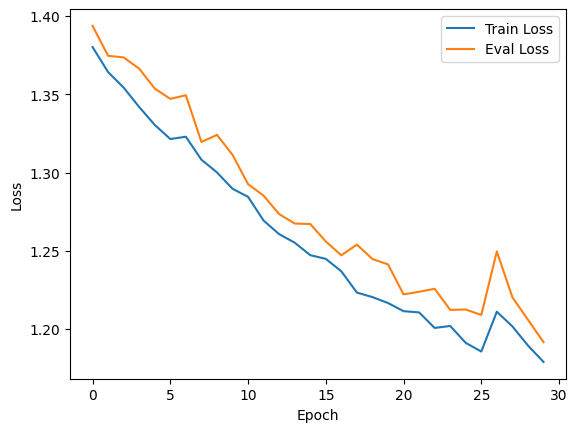

In [34]:
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 30
model.to(device)

train_loss_list = []
eval_loss_list = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    total_eval_loss = 0
    num_train_batches = 0
    num_eval_batches = 0

    # Training phase
    for vectors, labels in train_dataloader:
        optimizer.zero_grad()
        vectors=vectors.to(device)
        labels=labels.to(device)
        outputs = model(vectors)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        total_train_loss += loss.item()
        num_train_batches += 1
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / num_train_batches
    train_loss_list.append(avg_train_loss)

    # Evaluation phase
    model.eval()
    with torch.no_grad():
        for vectors, labels in eval_dataloader:
            outputs = model(sequence=vectors.to(device))
            loss = nn.CrossEntropyLoss()(outputs, labels.to(device))
            total_eval_loss += loss.item()
            num_eval_batches += 1

    avg_eval_loss = total_eval_loss / num_eval_batches
    eval_loss_list.append(avg_eval_loss)

    print(f"Epoch: {epoch} | Train Loss: {avg_train_loss:.5f}, Eval Loss: {avg_eval_loss:.5f}")

# Plotting outside the loop
plt.plot(train_loss_list, label='Train Loss')
plt.plot(eval_loss_list, label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for vectors, labels in test_dataloader:
        vectors = vectors.to(device)
        outputs = model(vectors)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

predictions = np.array(predictions)
true_labels = np.array(true_labels)

accuracy = np.mean(predictions == true_labels)
print(f"Test Accuracy: {accuracy:.5f}")

Test Accuracy: 0.75749


In [36]:
predictions

array([3, 1, 2, 1, 0, 0, 0, 3, 1, 0, 0, 0, 0, 3, 1, 3, 0, 0, 1, 2, 1, 3,
       3, 0, 1, 3, 2, 1, 1, 3, 0, 1, 3, 1, 2, 0, 2, 0, 3, 0, 1, 3, 2, 0,
       0, 0, 2, 2, 3, 3, 1, 0, 2, 2, 3, 1, 2, 0, 2, 0, 0, 0, 3, 2, 3, 1,
       2, 2, 3, 3, 2, 0, 3, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 3, 3, 3, 1,
       1, 1, 0, 1, 1, 1, 2, 2, 0, 2, 0, 0, 3, 1, 3, 0, 1, 2, 1, 3, 0, 0,
       2, 0, 1, 1, 1, 2, 1, 2, 0, 3, 1, 3, 2, 2, 1, 0, 3, 2, 2, 2, 2, 0,
       1, 1, 3, 0, 3, 3, 1, 1, 1, 3, 3, 2, 1, 0, 1, 2, 0, 3, 0, 2, 2, 0,
       1, 2, 0, 0, 2, 0, 0, 2, 1, 3, 0, 0, 0, 3, 3, 1, 0, 2, 2, 1, 0, 3,
       1, 1, 0, 1, 2, 0, 0, 3, 2, 0, 3, 2, 1, 3, 2, 0, 2, 3, 3, 1, 2, 3,
       0, 2, 1, 0, 0, 2, 2, 2, 0, 1, 0, 3, 0, 0, 3, 0, 1, 3, 1, 2, 0, 0,
       0, 3, 1, 0, 3, 0, 2, 3, 0, 2, 2, 1, 3, 1, 2, 1, 0, 1, 3, 0, 2, 0,
       3, 2, 2, 3, 0, 0, 1, 2, 1, 3, 0, 1, 1, 0, 1, 3, 0, 3, 0, 1, 3, 2,
       1, 3, 2, 2, 2, 2, 2, 0, 2, 3, 1, 3, 2, 1, 0, 2, 3, 1, 0, 0, 1, 2,
       3, 2, 2, 2, 1, 0, 2, 0, 2, 2, 3, 2, 0, 2, 1,

In [37]:
true_labels

array([3, 1, 1, 1, 4, 0, 4, 3, 1, 4, 0, 3, 0, 3, 1, 1, 0, 0, 1, 2, 1, 3,
       3, 0, 1, 3, 2, 1, 1, 3, 4, 1, 4, 1, 2, 4, 2, 0, 3, 0, 1, 3, 2, 0,
       0, 4, 2, 2, 3, 1, 4, 0, 2, 2, 1, 1, 2, 4, 2, 0, 4, 0, 3, 2, 3, 1,
       2, 2, 3, 3, 2, 4, 3, 2, 2, 0, 3, 0, 0, 2, 2, 0, 2, 4, 3, 3, 3, 1,
       1, 1, 4, 4, 4, 1, 2, 2, 0, 2, 0, 0, 3, 1, 3, 4, 1, 2, 1, 0, 4, 0,
       2, 4, 1, 1, 4, 4, 1, 2, 0, 3, 1, 3, 2, 2, 1, 0, 3, 2, 2, 2, 2, 0,
       1, 1, 3, 0, 3, 3, 1, 1, 1, 3, 1, 2, 1, 4, 1, 2, 3, 3, 4, 2, 2, 0,
       1, 4, 0, 4, 1, 0, 4, 2, 1, 3, 0, 4, 0, 3, 3, 1, 0, 2, 2, 1, 4, 3,
       1, 1, 3, 1, 2, 4, 0, 4, 2, 4, 1, 2, 1, 3, 2, 0, 2, 1, 3, 4, 2, 3,
       0, 4, 1, 4, 4, 2, 2, 2, 0, 1, 0, 3, 0, 4, 1, 4, 1, 4, 1, 2, 4, 4,
       4, 3, 1, 0, 3, 2, 2, 4, 0, 2, 2, 1, 4, 4, 2, 1, 0, 1, 3, 0, 2, 4,
       3, 2, 2, 1, 0, 4, 1, 0, 1, 4, 0, 1, 1, 4, 1, 3, 0, 3, 0, 1, 3, 2,
       1, 3, 4, 2, 2, 2, 2, 3, 2, 3, 1, 3, 2, 1, 0, 2, 3, 1, 0, 0, 1, 0,
       3, 2, 2, 4, 1, 4, 2, 4, 2, 2, 3, 2, 0, 2, 1,

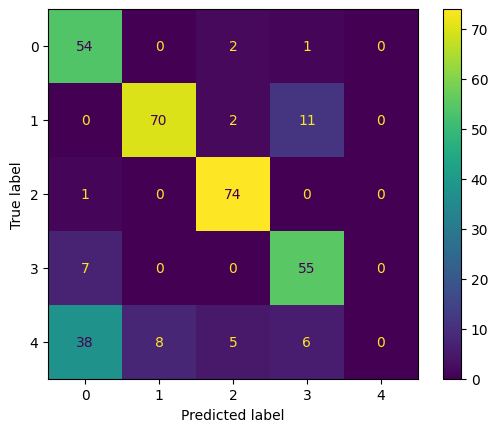

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(true_labels, predictions, labels=range(5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=range(5))
disp.plot()

a bunch of mitakes happening due to misconfusion between 4 and 0